# Comprehensive Fire, Beetle, and Drought Disturbance Analysis in Western US Forests

This notebook analyzes three major types of forest disturbances—fire, beetle infestations, and drought—across the Western United States. The workflow involves processing annual forest disturbance data to isolate areas affected by each disturbance type, aggregating them over multiple time periods, and generating outputs that highlight both individual and combined disturbance effects.

The analysis includes:
- Identifying regions affected by fire, beetles, and drought by processing annual forest disturbance raster data.
- Aggregating disturbance data over five-year intervals to track regions experiencing multiple years of fire, beetle, or drought-related disturbances.
- Summarizing the total area affected by each disturbance type individually, as well as areas experiencing multiple disturbance types over time.
- Visualizing the trends and interactions between fire, beetle, and drought disturbances with plots and geospatial outputs.

The output includes:
- Geospatial raster files showing annual presence for fire, beetle, and drought disturbances.
- Aggregated raster files showing the total number of years impacted by fire, beetles, and drought over five-year periods.
- Plots visualizing the total area affected by each disturbance type, as well as combined disturbance effects, over time.

This analysis provides insights into how fire, beetle infestations, and drought have individually and collectively impacted forest ecosystems in the Western US over time.

In [1]:
# Importing packages and setting paths
import os
from glob import glob
import earthpy as et
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import gc

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

forest_folder = path.join(home, "forest-disturbance-stack", "western-conus")
all_folder = path.join(home, "forest-disturbance-stack", "all-western-conus")
fiveyear_all_folder = path.join(home, "forest-disturbance-stack", "five-year-all")

forest_tif_list = sorted(glob(path.join(forest_folder, "forest-disturbance-stack_western-conus_*.tif")))

In [4]:
# Find all areas that had more than one disturbance in each time period

year_totals_over_2 = {}

with rio.open(forest_tif_list[0]) as src:
    total_array = np.zeros(src.shape)

for i, tif in enumerate(forest_tif_list):
    if i >=4:
        years = forest_tif_list[i-4:i+1]
        start_year = years[0][-8:-4]
        end_year = years[4][-8:-4]
        print("Processing years {} to {}".format(start_year, end_year))
        with rio.open(years[0]) as src:
            years_array = src.read(1)
            years_array[years_array == 2] = 1
            years_array[years_array == 6] = 1
            years_array[years_array == 10] = 1
            years_array[years_array == 14] = 2
            years_array[years_array == 1] = 1
            years_array[years_array == 5] = 1
            years_array[years_array == 9] = 1
            years_array[years_array == 13] = 2
            years_array[years_array >= 15] = 1
            years_array[years_array > 2] = 0
            meta = src.profile
        for year in years[1:]:
            with rio.open(year) as src:
                array = src.read(1)
            array[array == 2] = 1
            array[array == 6] = 1
            array[array == 10] = 1
            array[array == 14] = 2
            array[array == 1] = 1
            array[array == 5] = 1
            array[array == 9] = 1
            array[array == 13] = 2
            array[array >= 15] = 1
            array[array > 2] = 0
            years_array += array
            del(array)
            gc.collect()
        years_array[years_array <= 1] = 0
        with rio.open(path.join(fiveyear_all_folder, "disturbance_totals_{}-{}.tif".format(start_year, end_year)), 'w', **meta) as dst:
            dst.write(years_array, 1)
        years_array[years_array > 1] = 1
        year_totals_over_2[end_year] = (years_array.sum()* 30 * 30)/1000000    
        del(years_array)
        gc.collect()

Processing years 1999 to 2003
Processing years 2000 to 2004
Processing years 2001 to 2005
Processing years 2002 to 2006
Processing years 2003 to 2007
Processing years 2004 to 2008
Processing years 2005 to 2009
Processing years 2006 to 2010
Processing years 2007 to 2011
Processing years 2008 to 2012
Processing years 2009 to 2013
Processing years 2010 to 2014
Processing years 2011 to 2015
Processing years 2012 to 2016
Processing years 2013 to 2017
Processing years 2014 to 2018
Processing years 2015 to 2019
Processing years 2016 to 2020


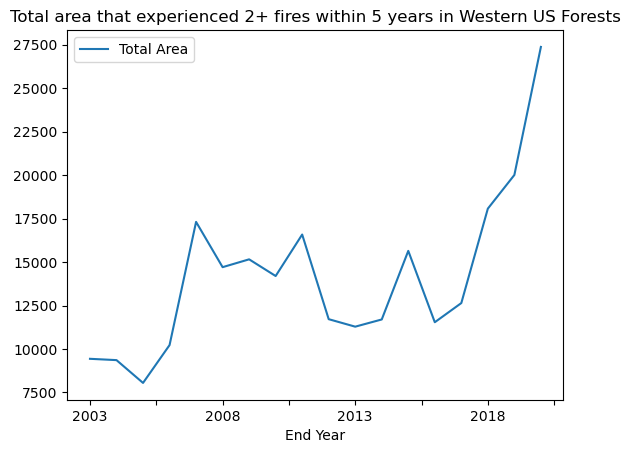

In [6]:
# Rearrange and plot the data
years = list(year_totals_over_2.keys())
area = list(year_totals_over_2.values())
data = {'End Year': years, 'Total Area': area}
short_term_plot = pd.DataFrame(data)

fig, ax = plt.subplots()
short_term_plot.plot('End Year',
                    y='Total Area', 
                    title='Total area that experienced 2+ fires within 5 years in Western US Forests',
                    ax=ax)
plt.show()

In [7]:
short_term_plot.to_csv(os.path.join(fiveyear_all_folder, 'all_area_over_time.csv'))

In [8]:
# Write out data

totals_path = glob(path.join(fiveyear_all_folder, "disturbance_totals_*.tif"))

with rio.open(totals_path[0]) as src:
    sum_array = src.read(1)

for tif in totals_path[1:]:
    with rio.open(tif) as src:
        array = src.read(1)
        sum_array += array
    del(array)

sum_array[sum_array>1] = 0 

area_with_short_interval = (sum_array.sum()* 30 * 30)/1000000    
print(area_with_short_interval)

0.0


In [9]:
disturbed_area = 664652.4   
print(disturbed_area)

area_with_short_interval/disturbed_area

664652.4


0.0

In [10]:
short_list = glob(path.join(fiveyear_all_folder, "disturbance_totals_*.tif"))

with rio.open(short_list[0]) as src:
    short_array = src.read(1)


for tif in short_list[1:]:
    with rio.open(tif) as src:
        array = src.read(1)
        short_array += array
    del(array)

short_array[short_array > 0] = 1

short_total = (short_array.sum()* 30 * 30)/1000000

print(short_total)

73569.9816


In [11]:
totals_path = glob(path.join(fiveyear_all_folder, "disturbance_totals_*.tif"))

with rio.open(totals_path[0]) as src:
    sum_array = src.read(1)

for tif in totals_path[1:]:
    with rio.open(tif) as src:
        array = src.read(1)
        sum_array += array
    del(array)

sum_array[sum_array>1] = 0 

area_with_short_interval = (sum_array.sum()* 30 * 30)/1000000    
print(area_with_short_interval)

0.0
